In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
plt.rcParams['font.family'] = 'D2Coding'
import seaborn as sns 

from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

import FinanceDataReader as fdr 
fdr.__version__

'0.9.50'

In [2]:
import warnings 

warnings.filterwarnings(action='ignore')

# Global Variables

In [3]:
import sys 

sys.path.append("../")

In [4]:
from asset.common.utils import reset_seeds

In [5]:
import easydict
args = easydict.EasyDict()

args.SEED = 42

args.df_corps_path = '../data/meta/stock_corps.csv'
args.save_stock_raw_path = '../data/stock/raw/{stock_code}.csv'
args.save_stock_preprocessing_path = '../data/stock/preprocessing/{stock_code}.csv'

# Read Corps

In [6]:
df_dtype = {
    'stock_code': 'object'
}

df_corps = pd.read_csv(args.df_corps_path, dtype=df_dtype)

print(f'{df_corps.shape} / {df_corps.isnull().sum().sum()}')
df_corps.head()

(2494, 13) / 20


,corp_code,corp_name,stock_code,corp_cls,corp_cls_nm,sector,product,industry_wics_ss_nm,industry_wics_ss_cd,industry_wics_ms_cd,industry_wics_ms_nm,industry_wics_ls_cd,industry_wics_ls_nm
0,956028,엑세스바이오,950130,K,kosdaq,의료용품 및 기타 의약 관련제품 제조업,"말라리아 진단키트(RDT), HIV 진단키트(RDT)",생명과학도구및서비스,352030,3520,제약과생물공학,35,건강관리
1,783246,글로벌에스엠,900070,K,kosdaq,기타 금융업,"자회사 제품 : IT기기용 정밀 화스너부품(스크류, 샤프트, 스프링)",자동차부품,251010,2510,자동차와부품,25,경기관련소비재
2,1170962,GRT,900290,K,kosdaq,기타 금융업,"광학필름, 포장필름",화학,151010,1510,소재,15,소재
3,600013,맵스리얼티1,094800,Y,kospi,신탁업 및 집합투자업,NaN,미분류,0,0,NaN,0,NaN
4,1139266,로스웰,900260,K,kosdaq,기타 금융업,"CAN Control Gateway, CAN기능모듈, BCM 차체제어모듈",자동차부품,251010,2510,자동차와부품,25,경기관련소비재


In [32]:
# 종목별로 stock_df 만들어서 딕셔너리 stock_df_dict에 저장하기 
stock_df_dict = {}

for stock_code in tqdm(df_corps['stock_code'].values): 

    df = fdr.DataReader(stock_code, start = '2000', end = None).reset_index()

    # 연, 월, 주, 일, 요일, 월별주수 정보 추가
    # df['Year'] = df['Date'].dt.year
    # df['Month'] = df['Date'].dt.month
    # df['Week'] = df['Date'].dt.isocalendar()['week'].astype(int)
    # df['Day'] = df['Date'].dt.day
    # df['Weekday'] = df['Date'].dt.weekday
    # df['WeekNum'] = np.ceil(df['Day']/7).astype(int)
    
    df = df.set_index('Date') 

    save_path = args.save_stock_raw_path.format(stock_code=stock_code)
    df.to_csv(save_path, header=True, index=True, encoding='utf-8')

    stock_df_dict[stock_code] = df

100%|██████████| 2494/2494 [06:19<00:00,  6.57it/s]


In [33]:
df_corps['stock_code'].unique()

array(['950130', '900070', '900290', ..., '154040', '424980', '003530'],
      dtype=object)

In [34]:
from asset.common.utils import load_stock

In [93]:
stock_df_dict = load_stock(df_corps['stock_code'].unique(), args.save_stock_raw_path)

stock_df_dict.keys()

100%|██████████| 2494/2494 [00:07<00:00, 339.61it/s]


dict_keys(['950130', '900070', '900290', '094800', '900260', '950160', '950110', '088980', '900250', '950220', '064260', '054050', '001810', '060560', '105840', '015750', '150900', '101930', '005710', '000490', '036540', '001820', '000910', '038870', '049800', '001020', '058400', '005720', '023600', '104040', '200880', '001070', '011420', '217500', '058220', '900310', '089790', '293780', '082740', '026150', '900300', '000700', '004540', '053060', '217730', '014620', '900110', '048870', '376180', '006340', '013720', '072020', '005870', '068240', '010960', '001630', '139990', '011280', '263860', '031440', '006910', '241520', '357780', '014530', '363250', '053450', '286940', '900140', '117730', '225530', '005690', '070960', '097800', '311320', '015860', '244460', '299030', '002620', '006390', '001260', '237750', '367000', '067160', '004700', '263690', '276040', '071670', '084730', '281740', '189300', '001520', '214260', '332370', '032300', '361670', '041520', '317240', '109820', '058970',

# Preprocessing Data

## Close값 보정: 상한가/하한가
> 우리나라는 법적으로 하루동안 최대 30% 이상 변동성이 발생할 수 없음

In [94]:
df_corps[df_corps['stock_code'] == '109960']

,corp_code,corp_name,stock_code,corp_cls,corp_cls_nm,sector,product,industry_wics_ss_nm,industry_wics_ss_cd,industry_wics_ms_cd,industry_wics_ms_nm,industry_wics_ls_cd,industry_wics_ls_nm
1398,653194,에이프로젠 H&G,109960,K,kosdaq,기타 전문 도매업,"모바일게임 퍼블리싱, 바이오의약품 연구개발업 및 판매, 생산설비 및 연구장비의 대여...",제약,352020,3520,제약과생물공학,35,건강관리


In [95]:
df_tmp = stock_df_dict['109960'].copy() 
(df_tmp.loc['2023-04-07']['Close'] - df_tmp.loc['2023-03-17']['Close']) / df_tmp.loc['2023-03-17']['Close']

4.99163179916318

Open, High, Low, Volume 값들이 0인 경우에는 해당 기간동안 거래가 정지된 경우이다.

In [96]:
df_tmp['2023-03-17':'2023-04-07']

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-03-17,238,255,236,239,1482966,0.008439
2023-03-20,0,0,0,239,0,0.000000
2023-03-21,0,0,0,239,0,0.000000
2023-03-22,0,0,0,239,0,0.000000
2023-03-23,0,0,0,239,0,0.000000
2023-03-24,0,0,0,239,0,0.000000
2023-03-27,0,0,0,239,0,0.000000
2023-03-28,0,0,0,239,0,0.000000
2023-03-29,0,0,0,239,0,0.000000


In [97]:
df_tmp['diff'] = df_tmp['Close'].diff()

In [98]:
df_tmp.head()

,Open,High,Low,Close,Volume,Change,diff
Date,,,,,,,
2009-11-13,978,1122,978,1123,307831,NaN,NaN
2009-11-16,1216,1250,957,957,754026,-0.147818,-166.0
2009-11-17,888,918,842,859,656578,-0.102403,-98.0
2009-11-18,859,922,813,821,402570,-0.044237,-38.0
2009-11-19,828,832,766,772,213569,-0.059683,-49.0


In [99]:
df_tmp['diff_temp'] = df_tmp['diff'] / (df_tmp['Close'] - df_tmp['diff'])
df_tmp.head()

,Open,High,Low,Close,Volume,Change,diff,diff_temp
Date,,,,,,,,
2009-11-13,978,1122,978,1123,307831,NaN,NaN,NaN
2009-11-16,1216,1250,957,957,754026,-0.147818,-166.0,-0.147818
2009-11-17,888,918,842,859,656578,-0.102403,-98.0,-0.102403
2009-11-18,859,922,813,821,402570,-0.044237,-38.0,-0.044237
2009-11-19,828,832,766,772,213569,-0.059683,-49.0,-0.059683


In [100]:
df_tmp['2023-03-17':'2023-04-07']

,Open,High,Low,Close,Volume,Change,diff,diff_temp
Date,,,,,,,,
2023-03-17,238,255,236,239,1482966,0.008439,2.0,0.008439
2023-03-20,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-21,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-22,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-23,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-24,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-27,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-28,0,0,0,239,0,0.000000,0.0,0.000000
2023-03-29,0,0,0,239,0,0.000000,0.0,0.000000


In [101]:
def correcte_change(row):
    try:
        return row['diff'] / (row['Close'] - row['diff'])
    except:
        return row['Change']

In [102]:
def correcte_close(p_df):
    c1 = p_df['Change'] >= 0.3
    c2 = p_df['Change'] <= -0.3
    c = c1 | c2
    _outlier_dt_str = p_df.loc[c].index[0]
    _outlier_dt_change = p_df.loc[_outlier_dt_str]['Change']

    if isinstance(_outlier_dt_str, str):
        _outlier_dt = datetime.strptime(_outlier_dt_str, '%Y-%m-%d')
    else:
        _outlier_dt = _outlier_dt_str
    _end_dt = _outlier_dt + relativedelta(days=-1)
    _end_dt_str = _end_dt.strftime("%Y-%m-%d")
    from_df = p_df[:_end_dt_str]
    from_df['Open'] = from_df['Open'].map(lambda x: x*_outlier_dt_change) # Open 보정
    from_df['High'] = from_df['High'].map(lambda x: x*_outlier_dt_change) # High 보정
    from_df['Low'] = from_df['Low'].map(lambda x: x*_outlier_dt_change) # Low 보정
    from_df['Close'] = from_df['Close'].map(lambda x: x*_outlier_dt_change) # Close 보정
    
    _df = pd.concat([from_df,p_df[_outlier_dt_str:]], axis=0)
    _df['diff'] = _df['Close'].diff()
    _df['Change'] = _df.apply(correcte_change, axis=1) # Change 보정 
    return _df 

In [103]:
reset_seeds(args.SEED)

for stock_code in tqdm(stock_df_dict.keys()):
    stock_df = stock_df_dict[stock_code]

    _min = stock_df['Change'].describe()['min']
    _max = stock_df['Change'].describe()['max']
    if abs(_min) >= 0.3 or abs(_max ) >= 0.3:
        stock_df = correcte_close(stock_df)
        stock_df = stock_df.drop(columns=['diff']) # diff 제거 

    stock_df = stock_df[stock_df['Open'] > 0] # 거래정지 경우 제외
    stock_df_dict[stock_code] = stock_df

100%|██████████| 2494/2494 [00:17<00:00, 139.88it/s]


In [104]:
df_tmp = stock_df_dict['109960'].copy() 
(df_tmp.loc['2023-04-07']['Close'] - df_tmp.loc['2023-03-17']['Close']) / df_tmp.loc['2023-03-17']['Close']

0.20033528918692373

In [105]:
df_tmp['2023-03-17':'2023-04-07']

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-03-17,1188.008368,1272.866109,1178.025105,1193.0,1482966,0.008439
2023-04-07,1425.000000,1597.000000,1308.000000,1432.0,1311805,0.200335


## 추가 변수 생성 

- 일일 등락률(Day_Range)
    - 종가에서 시가를 빼 값에서 시가로 나눈 값 

In [106]:
df_tmp = stock_df_dict['109960'].copy() 
df_tmp.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2009-11-13,4881.815900,5600.610879,4881.815900,5605.602510,307831,NaN
2009-11-16,6069.824268,6239.539749,4776.991632,4776.991632,754026,-0.147818
2009-11-17,4432.569038,4582.317992,4202.953975,4287.811715,656578,-0.102403
2009-11-18,4287.811715,4602.284519,4058.196653,4098.129707,402570,-0.044237
2009-11-19,4133.071130,4153.037657,3823.589958,3853.539749,213569,-0.059683


In [107]:
df_tmp["Day_Range"] = (df_tmp['Close'] - df_tmp['Open']) / df_tmp['Open']
df_tmp.head()

,Open,High,Low,Close,Volume,Change,Day_Range
Date,,,,,,,
2009-11-13,4881.815900,5600.610879,4881.815900,5605.602510,307831,NaN,0.148262
2009-11-16,6069.824268,6239.539749,4776.991632,4776.991632,754026,-0.147818,-0.212993
2009-11-17,4432.569038,4582.317992,4202.953975,4287.811715,656578,-0.102403,-0.032658
2009-11-18,4287.811715,4602.284519,4058.196653,4098.129707,402570,-0.044237,-0.044237
2009-11-19,4133.071130,4153.037657,3823.589958,3853.539749,213569,-0.059683,-0.067633


In [108]:
df_tmp.describe()

,Open,High,Low,Close,Volume,Change,Day_Range
count,3377.000000,3377.000000,3377.000000,3377.000000,3.377000e+03,3376.000000,3377.000000
mean,5523.471120,5678.910884,5337.792487,5499.271779,1.077576e+06,0.000611,-0.003025
std,4524.075034,4674.096310,4325.778745,4493.605178,7.090168e+06,0.043477,0.042169
min,1188.008368,1237.924686,1173.033473,1183.016736,1.000000e+00,-0.228495,-0.254988
25%,2745.397490,2820.271967,2660.539749,2745.397490,1.458200e+04,-0.018737,-0.021994
50%,3713.774059,3793.640167,3628.916318,3693.807531,1.051610e+05,-0.001080,-0.003591
75%,6164.665272,6349.355649,5965.000000,6114.748954,4.176030e+05,0.012822,0.012987
max,30788.384937,31382.389121,27813.372385,30199.372385,1.790017e+08,0.299886,0.313333


In [115]:
reset_seeds(args.SEED)

for stock_code in tqdm(stock_df_dict.keys()):
    stock_df = stock_df_dict[stock_code]
    stock_df["Day_Range"] = (stock_df['Close'] - stock_df['Open']) / stock_df['Open']
    stock_df = stock_df.dropna()
    stock_df_dict[stock_code] = stock_df


100%|██████████| 2494/2494 [00:00<00:00, 2875.56it/s]


In [116]:
stock_df_dict.keys()

dict_keys(['950130', '900070', '900290', '094800', '900260', '950160', '950110', '088980', '900250', '950220', '064260', '054050', '001810', '060560', '105840', '015750', '150900', '101930', '005710', '000490', '036540', '001820', '000910', '038870', '049800', '001020', '058400', '005720', '023600', '104040', '200880', '001070', '011420', '217500', '058220', '900310', '089790', '293780', '082740', '026150', '900300', '000700', '004540', '053060', '217730', '014620', '900110', '048870', '376180', '006340', '013720', '072020', '005870', '068240', '010960', '001630', '139990', '011280', '263860', '031440', '006910', '241520', '357780', '014530', '363250', '053450', '286940', '900140', '117730', '225530', '005690', '070960', '097800', '311320', '015860', '244460', '299030', '002620', '006390', '001260', '237750', '367000', '067160', '004700', '263690', '276040', '071670', '084730', '281740', '189300', '001520', '214260', '332370', '032300', '361670', '041520', '317240', '109820', '058970',

In [117]:
stock_df_dict['900070'].head()

,Open,High,Low,Close,Volume,Change,Day_Range
Date,,,,,,,
2009-12-24,2588,2648,2256,2352,3728532,-0.076923,-0.091190
2009-12-28,2324,2435,2264,2352,1987712,0.000000,0.012048
2009-12-29,2341,2406,2303,2304,1124723,-0.020408,-0.015805
2009-12-30,2289,2344,2222,2304,1964120,0.000000,0.006553
2010-01-04,2312,2505,2312,2448,1208960,0.062500,0.058824


## [TA(Technical Analysis) 라이브러리를 이용한 변수 추가](https://github.com/bukosabino/ta)
- https://inhovation97.tistory.com/58

In [118]:
import ta

In [119]:
reset_seeds()

for stock_code in tqdm(stock_df_dict.keys()):
    stock_df = stock_df_dict[stock_code]

    H, L, C, V = stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume']

    stock_df['ta_bol_high'] = ta.volatility.bollinger_hband(C)
    stock_df['ta_bol_low']  = ta.volatility.bollinger_lband(C)
    stock_df['ta_MFI'] = ta.volume.money_flow_index(
        high=H, low=L, close=C, volume=V, fillna=True)

    # stock_df['ADI'] = ta.volume.acc_dist_index(high=H, low=L, close=C, volume=V, fillna=True)

    stock_df['ta_OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
    # stock_df['CMF'] = ta.volume.chaikin_money_flow(high=H, low=L, close=C, volume=V, fillna=True)

    stock_df['ta_FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
    stock_df['ta_EOM, ta_EMV'] = ta.volume.ease_of_movement(
        high=H, low=L, volume=V, fillna=True)

    stock_df['ta_VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
    stock_df['ta_NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
    stock_df['ta_VMAP'] = ta.volume.volume_weighted_average_price(
        high=H, low=L, close=C, volume=V, fillna=True)

    # Volatility
    # stock_df['ATR'] = ta.volatility.average_true_range(high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
    stock_df['ta_v_BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
    stock_df['ta_v_KCH'] = ta.volatility.keltner_channel_hband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_KCL'] = ta.volatility.keltner_channel_lband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_KCM'] = ta.volatility.keltner_channel_mband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_DCH'] = ta.volatility.donchian_channel_hband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_DCL'] = ta.volatility.donchian_channel_lband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_DCM'] = ta.volatility.donchian_channel_mband(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_v_UI'] = ta.volatility.ulcer_index(close=C, fillna=True)

    # Trend
    stock_df['ta_t_SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
    stock_df['ta_t_EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
    stock_df['ta_t_WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
    stock_df['ta_t_MACD'] = ta.trend.macd(close=C, fillna=True)
    # stock_df['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
    stock_df['ta_t_-VI'] = ta.trend.vortex_indicator_neg(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_t_+VI'] = ta.trend.vortex_indicator_pos(
        high=H, low=L, close=C, fillna=True)
    stock_df['ta_t_TRIX'] = ta.trend.trix(close=C, fillna=True)
    stock_df['ta_t_MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
    # stock_df['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
    stock_df['ta_t_DPO'] = ta.trend.dpo(close=C, fillna=True)
    stock_df['ta_t_KST'] = ta.trend.kst(close=C, fillna=True)
    stock_df['ta_t_Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
    stock_df['ta_t_Parabolic SAR'] = ta.trend.psar_down(high=H, low=L, close=C, fillna=True)
    stock_df['ta_t_STC'] = ta.trend.stc(close=C, fillna=True)
    
    # Momentum
    stock_df['ta_m_RSI'] = ta.momentum.rsi(close=C, fillna=True)
    stock_df['ta_m_SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
    stock_df['ta_m_TSI'] = ta.momentum.tsi(close=C, fillna=True)
    # stock_df['UO'] = ta.momentum.ultimate_oscillator(high=H, low=L, close=C, fillna=True)
    # stock_df['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
    # stock_df['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
    stock_df['ta_m_AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
    stock_df['ta_m_KAMA'] = ta.momentum.kama(close=C, fillna=True)
    stock_df['ta_m_ROC'] = ta.momentum.roc(close=C, fillna=True)
    stock_df['ta_m_PPO'] = ta.momentum.ppo(close=C, fillna=True)
    stock_df['ta_m_PVO'] = ta.momentum.pvo(volume=V, fillna=True)
    
    stock_df = stock_df.dropna()
    save_path = args.save_stock_preprocessing_path.format(stock_code=stock_code)
    stock_df.to_csv(save_path, header=True, index=True, encoding='utf-8')
    
    stock_df_dict[stock_code] = stock_df

100%|██████████| 2494/2494 [19:36<00:00,  2.12it/s]


# 분석

In [123]:
print(stock_df_dict['900070'].shape)
stock_df_dict['900070'].head()

(3344, 46)


,Open,High,Low,Close,Volume,Change,Day_Range,ta_bol_high,ta_bol_low,ta_MFI,...,ta_t_Parabolic SAR,ta_t_STC,ta_m_RSI,ta_m_SRSI,ta_m_TSI,ta_m_AO,ta_m_KAMA,ta_m_ROC,ta_m_PPO,ta_m_PVO
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-25,2498,2617,2432,2465,388770,-0.036733,-0.013211,2743.334514,2258.865486,63.778179,...,2608.242560,56.233056,47.791487,0.007301,21.797373,99.500000,2364.092515,-3.029111,2.177283,-45.912645
2010-01-26,2526,2526,2268,2318,321952,-0.059635,-0.082344,2746.229820,2252.570180,49.060465,...,2771.000000,28.116528,38.398254,0.000000,12.219431,46.795238,2363.900663,-7.906238,1.284299,-47.843212
2010-01-27,2324,2406,2275,2405,265568,0.037532,0.034854,2743.573891,2260.526109,53.285161,...,2760.940000,14.058264,45.256088,0.207076,7.684230,-18.440909,2364.071732,-5.240347,0.842637,-49.915425
2010-01-28,2427,2427,2330,2367,129828,-0.015800,-0.024722,2737.787704,2272.612296,57.330950,...,2751.081200,7.029132,43.004165,0.139078,3.468212,-63.686957,2364.083920,-6.590371,0.363447,-52.947136
2010-01-29,2312,2355,2268,2276,129101,-0.038445,-0.015571,2741.496109,2266.103891,52.008481,...,2741.419576,3.514566,38.113202,0.000000,-1.807942,-96.079167,2363.717286,-5.206164,-0.314254,-55.611002


In [120]:
stock_dicts = []

for stock_code in stock_df_dict.keys():
    stock_df = stock_df_dict[stock_code]
    
    stock_dicts.append(
        {
            'stock_code': stock_code,
            'row_num':stock_df.shape[0]
        }
    )

len(stock_dicts)

2494

최대 데이터 크기 : 5811
최소 데이터 크기 : 0
평균 데이터 크기 : 3346.314755412991


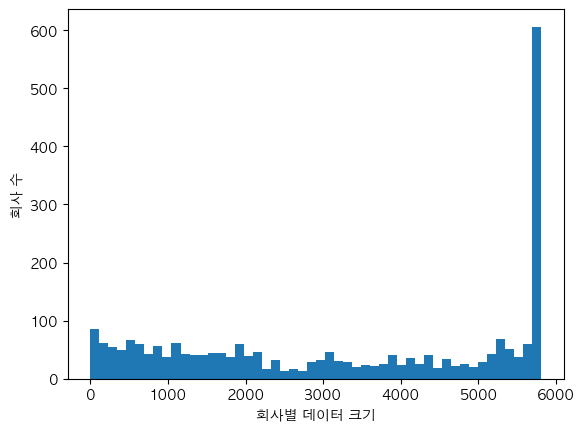

In [125]:
import matplotlib.pyplot as plt

stock_row_num_list = [ stock['row_num'] for stock in stock_dicts]

print('최대 데이터 크기 :',max(row_num for row_num in stock_row_num_list))
print('최소 데이터 크기 :',min(row_num for row_num in stock_row_num_list))
print('평균 데이터 크기 :',sum(stock_row_num_list)/len(stock_row_num_list))

plt.hist([row_num for row_num in stock_row_num_list], bins=50)
plt.xlabel('회사별 데이터 크기')
plt.ylabel('회사 수')
plt.show()